In [ ]:
import numpy as np 
import pandas as pd
import xgboost as xgb
import catboost as cb
import matplotlib.pyplot as plt
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

shap.initjs()

In [2]:
data = pd.read_csv('./ieee-fraud-detection/data.csv')
data.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
columns = ['isFraud', 'TransactionAmt', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1']

In [4]:
data_hw = data[columns]
data_hw.head(n=2)

,isFraud,TransactionAmt,card1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1
0,0,68.5,13926,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0
1,0,29.0,2755,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [5]:
x_train, x_valid = train_test_split(
    data_hw.drop(['isFraud'], axis=1), train_size=0.7, shuffle=True, random_state=1,
)

y_train, y_valid = train_test_split(
    data_hw['isFraud'], train_size=0.7, shuffle=True, random_state=1,
)

In [6]:
baseline = xgb.XGBClassifier(random_state=27)
baseline.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=27, ...)

In [7]:
score = roc_auc_score(y_valid, baseline.predict_proba(x_valid)[:,1])
round(score,4)

0.9131

In [8]:
xgb_params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.1,
    'reg_lambda': 100,
    'max_depth': 4,
    'nthread': 10,
    'gamma': 10,
    'seed': 27
}

dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [9]:
evals_result = {}

model = xgb.train(
    params=xgb_params,
    dtrain = dtrain,
    num_boost_round=1000,
    maximize=True,
    early_stopping_rounds=50,
    evals_result=evals_result,
    evals = [(dtrain, 'train'), (dvalid, 'valid')],
    verbose_eval=25,
)

[0]	train-auc:0.59716	valid-auc:0.59101
[25]	train-auc:0.77596	valid-auc:0.76279
[50]	train-auc:0.86119	valid-auc:0.84977
[75]	train-auc:0.87138	valid-auc:0.85718
[100]	train-auc:0.87673	valid-auc:0.86125
[125]	train-auc:0.87673	valid-auc:0.86125
[146]	train-auc:0.87673	valid-auc:0.86125


Text(0, 0.5, 'ROC-AUC')

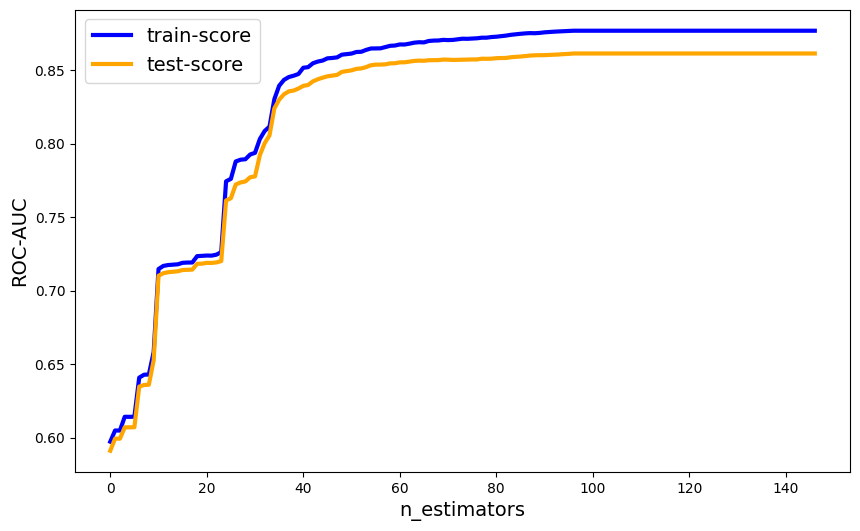

In [10]:
fig = plt.figure(figsize=(10,6))
plt.plot(evals_result['train']['auc'], linewidth=3, label='train-score', color='blue')
plt.plot(evals_result['valid']['auc'], linewidth=3, label='test-score', color='orange')
plt.legend(loc='best', fontsize=14)
plt.xlabel('n_estimators', size=14)
plt.ylabel('ROC-AUC', size=14)

In [11]:
no_nan_list = []
for i in range(len(data.isna().sum())):
               if data.isna().sum()[i] == 0:
                   no_nan_list.append(data.columns[i])
                
print(len(no_nan_list))

75


In [12]:
print(no_nan_list)

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']


In [13]:
columns = ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']

In [14]:
data_hw_2 = data[columns]

In [15]:
data_hw_2 = data_hw_2.drop(['ProductCD'], axis=1)

In [16]:
x_train, x_valid = train_test_split(
    data_hw_2.drop(['isFraud', 'TransactionID'], axis=1), train_size=0.7, shuffle=True, random_state=1,
)

y_train, y_valid = train_test_split(
    data_hw_2['isFraud'], train_size=0.7, shuffle=True, random_state=1,
)

In [17]:
xgb_params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.1,
    'reg_lambda': 100,
    'max_depth': 4,
    'nthread': 10,
    'gamma': 10,
    'seed': 27
}

dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [18]:
evals_result = {}

model = xgb.train(
    params=xgb_params,
    dtrain = dtrain,
    num_boost_round=1000,
    maximize=True,
    early_stopping_rounds=50,
    evals_result=evals_result,
    evals = [(dtrain, 'train'), (dvalid, 'valid')],
    verbose_eval=25,
)

[0]	train-auc:0.60582	valid-auc:0.59465
[25]	train-auc:0.81994	valid-auc:0.80090
[50]	train-auc:0.87211	valid-auc:0.85164
[75]	train-auc:0.88491	valid-auc:0.86474
[100]	train-auc:0.88850	valid-auc:0.86823
[125]	train-auc:0.88925	valid-auc:0.86855
[150]	train-auc:0.88925	valid-auc:0.86855
[152]	train-auc:0.88925	valid-auc:0.86855


Text(0, 0.5, 'ROC-AUC')

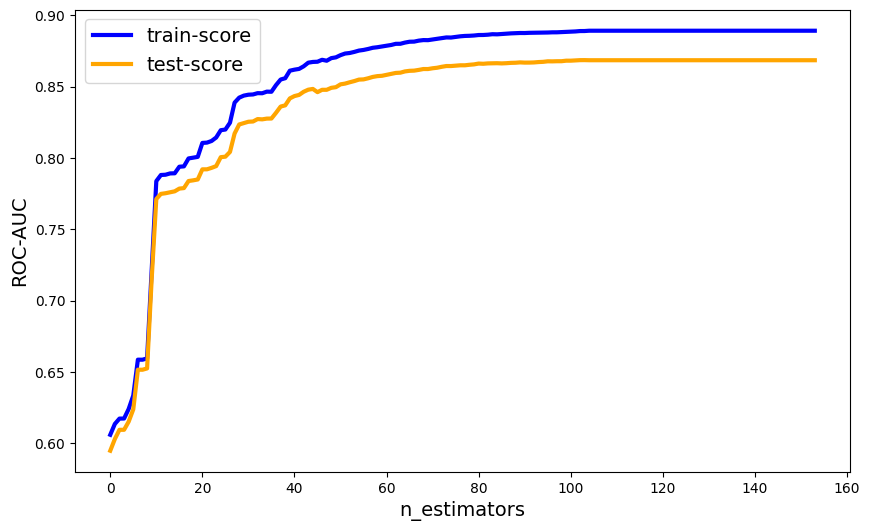

In [19]:
fig = plt.figure(figsize=(10,6))
plt.plot(evals_result['train']['auc'], linewidth=3, label='train-score', color='blue')
plt.plot(evals_result['valid']['auc'], linewidth=3, label='test-score', color='orange')
plt.legend(loc='best', fontsize=14)
plt.xlabel('n_estimators', size=14)
plt.ylabel('ROC-AUC', size=14)

In [20]:
cv_score= xgb.cv(
    dtrain=dtrain,
    params=xgb_params,
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=25,
    maximize=True,
    nfold=3,
)

[0]	train-auc:0.60791+0.00180	test-auc:0.60363+0.00203
[25]	train-auc:0.81532+0.00451	test-auc:0.80736+0.01009
[50]	train-auc:0.87081+0.00339	test-auc:0.86280+0.00613
[75]	train-auc:0.88173+0.00292	test-auc:0.87159+0.00765
[100]	train-auc:0.88305+0.00351	test-auc:0.87248+0.00691
[125]	train-auc:0.88305+0.00351	test-auc:0.87248+0.00691
[138]	train-auc:0.88305+0.00351	test-auc:0.87248+0.00691


Text(0, 0.5, 'ROC-AUC')

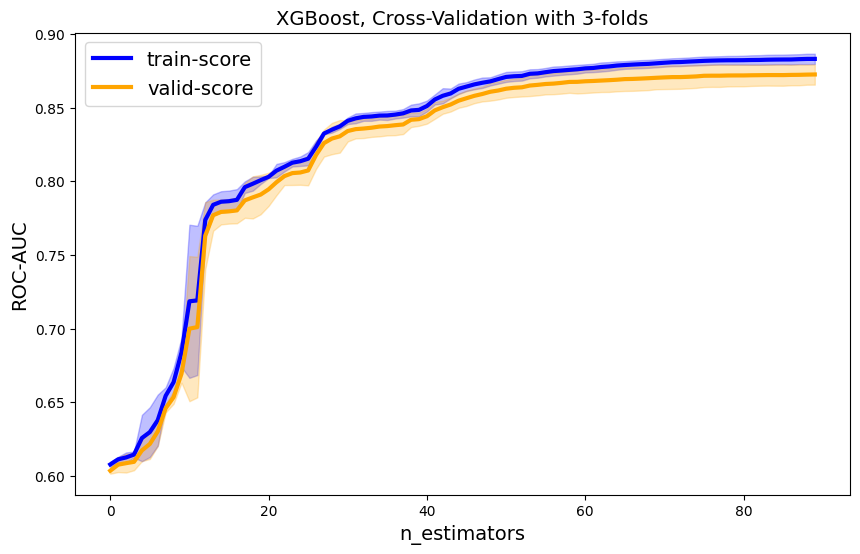

In [21]:
fig = plt.figure(figsize=(10, 6))
plt.title("XGBoost, Cross-Validation with 3-folds", size=14)
plt.plot(
    cv_score["train-auc-mean"],
    label="train-score",
    linewidth=3,
    color="blue"
)
plt.fill_between(
    x=range(cv_score.shape[0]),
    y1=cv_score["train-auc-mean"]-cv_score["train-auc-std"],
    y2=cv_score["train-auc-mean"]+cv_score["train-auc-std"],
    color="blue", alpha=0.25
)
plt.plot(
    cv_score["test-auc-mean"],
    label="valid-score",
    color="orange",
    linewidth=3
)
plt.fill_between(
    x=range(cv_score.shape[0]),
    y1=cv_score["test-auc-mean"]-cv_score["test-auc-std"],
    y2=cv_score["test-auc-mean"]+cv_score["test-auc-std"],
    color="orange", alpha=0.25
)
plt.legend(loc="best", fontsize=14)
plt.xlabel("n_estimators", size=14)
plt.ylabel("ROC-AUC", size=14)

In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid)

In [23]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0,:], x_valid.iloc[0,:],
    link='logit',
)

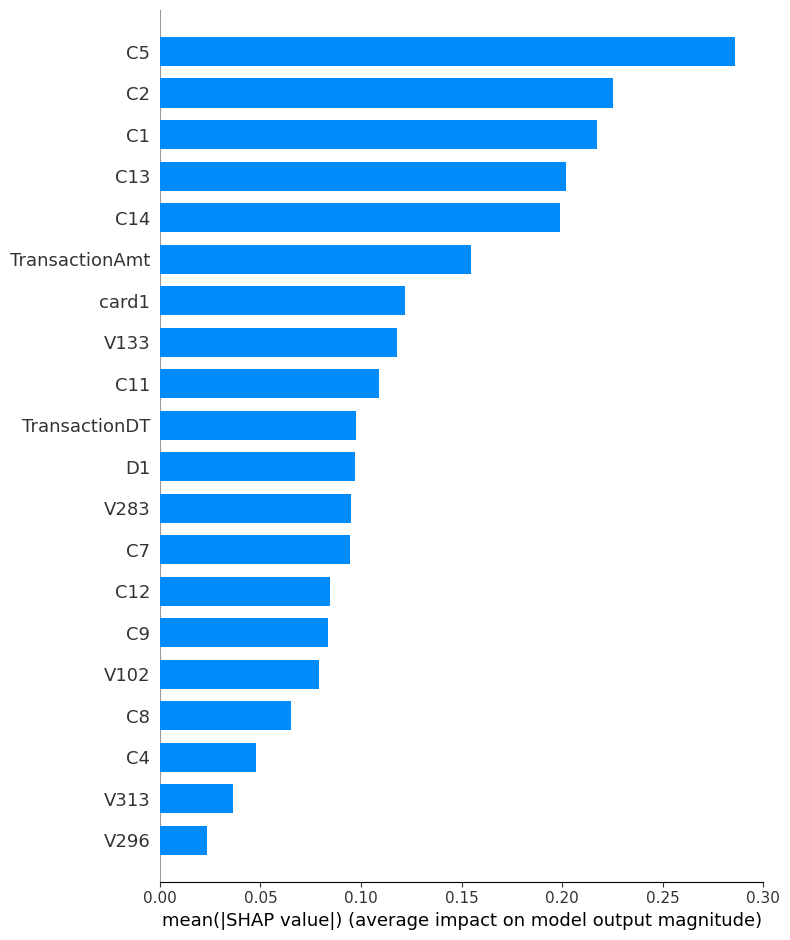

In [24]:
shap.summary_plot(
    shap_values, x_valid, plot_type='bar', max_display=20
)

In [25]:
model = cb.CatBoostClassifier(random_state=27)
model.fit(x_train, y_train)

Learning rate set to 0.063211
0:	learn: 0.5893894	total: 75.2ms	remaining: 1m 15s
1:	learn: 0.5017441	total: 85.7ms	remaining: 42.8s
2:	learn: 0.4337230	total: 97.2ms	remaining: 32.3s
3:	learn: 0.3769291	total: 108ms	remaining: 26.9s
4:	learn: 0.3311787	total: 118ms	remaining: 23.5s
5:	learn: 0.2900836	total: 129ms	remaining: 21.4s
6:	learn: 0.2571767	total: 140ms	remaining: 19.9s
7:	learn: 0.2334295	total: 150ms	remaining: 18.7s
8:	learn: 0.2113727	total: 161ms	remaining: 17.8s
9:	learn: 0.1933725	total: 173ms	remaining: 17.1s
10:	learn: 0.1797237	total: 184ms	remaining: 16.6s
11:	learn: 0.1661195	total: 197ms	remaining: 16.2s
12:	learn: 0.1561115	total: 209ms	remaining: 15.9s
13:	learn: 0.1473278	total: 222ms	remaining: 15.6s
14:	learn: 0.1393144	total: 236ms	remaining: 15.5s
15:	learn: 0.1317451	total: 248ms	remaining: 15.3s
16:	learn: 0.1265067	total: 260ms	remaining: 15s
17:	learn: 0.1213144	total: 273ms	remaining: 14.9s
18:	learn: 0.1173852	total: 285ms	remaining: 14.7s
19:	learn

In [26]:
score = roc_auc_score(y_valid, model.predict_proba(x_valid)[:,1])
round(score,4)

0.9091

In [28]:
cat_features = data.dtypes[data.dtypes == 'object'].index.tolist()
# cat_features = data[cat_features]
cat_features
# data['card4'].isna().sum()
data_hw_2[cat_features] = data[cat_features]
# data_hw_2.fillna(-9999)

In [29]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='most_frequent')

data_hw_2[cat_features] = imp.fit_transform(data_hw_2[cat_features])

In [30]:
col = ['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [31]:
x_train, x_valid = train_test_split(
    data_hw_2.drop(['isFraud', 'TransactionID'], axis=1), train_size=0.7, shuffle=True, random_state=1,
)

y_train, y_valid = train_test_split(
    data_hw_2['isFraud'], train_size=0.7, shuffle=True, random_state=1,
)

In [32]:
model = cb.CatBoostClassifier(random_state=27)

In [33]:
model.fit(x_train, y_train, cat_features=cat_features)

Learning rate set to 0.063211
0:	learn: 0.5870847	total: 44.1ms	remaining: 44s
1:	learn: 0.5015890	total: 87.5ms	remaining: 43.7s
2:	learn: 0.4321010	total: 141ms	remaining: 46.9s
3:	learn: 0.3758161	total: 190ms	remaining: 47.3s
4:	learn: 0.3268067	total: 246ms	remaining: 48.9s
5:	learn: 0.2885016	total: 303ms	remaining: 50.1s
6:	learn: 0.2556257	total: 355ms	remaining: 50.3s
7:	learn: 0.2300409	total: 419ms	remaining: 52s
8:	learn: 0.2102195	total: 484ms	remaining: 53.3s
9:	learn: 0.1924659	total: 544ms	remaining: 53.9s
10:	learn: 0.1774920	total: 600ms	remaining: 53.9s
11:	learn: 0.1636923	total: 656ms	remaining: 54s
12:	learn: 0.1531544	total: 711ms	remaining: 54s
13:	learn: 0.1443496	total: 769ms	remaining: 54.2s
14:	learn: 0.1364824	total: 821ms	remaining: 53.9s
15:	learn: 0.1303070	total: 877ms	remaining: 53.9s
16:	learn: 0.1245008	total: 926ms	remaining: 53.6s
17:	learn: 0.1205548	total: 983ms	remaining: 53.6s
18:	learn: 0.1171758	total: 1.03s	remaining: 53.5s
19:	learn: 0.1134

In [34]:
score = roc_auc_score(y_valid, model.predict_proba(x_valid)[:,1])
round(score,4)

0.9151